### RNN for prediction sin vawe

In [190]:
#importer
import torch
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))
from torch.nn import Module, Linear, MSELoss
from torch.nn import RNN as nn_RNN
from torch.optim import Adam
from ml_utils import parse_config, vizualization

In [191]:
VALID_JSON={
    "data":
    {
        "type":"object",
        "properties":
        {
            "wave":
            {
                "type":"string",
                "enum":["sin", "cos", "tan", "cotan"]
            },
            "time_start":
            {
                "type":int
            },
            "time_step":
            {
                "type":int
            },
            "time_stop":
            {
                "type":int
            }
        },
        "required":["wave", "time_start", "time_step", "time_stop"]
    },
    "hpr_prm":
    {
        "type":"object",
        "properties":
        {
            "lr":
            {
                "type":"number",
                "minimum":0.000001,
                "maximum":1.0
            },
            "act_f":
            {
                "type":"string",
                "enum":["sig", "tanh", "silu", "relu","identity"]
            },
            "hidden_size":
            {
                "type":"number"
            },
            "num_layers":
            {
                "type":"number"
            },
            "epochs":
            {
                "type":"integer"
            },
            "seq_len":
            {
                "type":"integer"
            }
        },
        "required":["act_f", "epochs", "lr", "hidden_size", "num_layers","seq_len"]
    },
    "required":["data", "hpr_prm"]
}

In [192]:
def create_data(wave:str, t:tuple):
    if wave == 'sin':
        return np.sin(t)
    elif wave == 'cos':
        return np.cos(t)
    elif wave == 'tan':
        return np.tan(t)
    
def create_dataset(data:np.ndarray, seq_len:int)->np.array:
    X = []
    y = []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+1])
    return X, y
 

In [193]:
class RNN(Module):
    def __init__(self, input_size:int, hidden_size:int, num_layers:int, output_size:int, non_lin:str) -> None:
        super().__init__()
        self.rnn = nn_RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity=non_lin)
        self.fc = Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out
    

In [194]:
def train(model:Module, criterion:MSELoss, optimizer:Adam, X_train:np.array, y_train:np.array, epochs:int):
    model.train()
    x_epoch = np.arange(0, epochs)
    y_loss = np.zeros(epochs, dtype=float)
    
    for epoch in range(epochs):
        output = model(X_train)
        optimizer.zero_grad()
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        y_loss[epoch] = loss.item()
        if epoch % 20 == 0:
            print(f'Epoch {epoch}/{epochs} finished with avg loss: {y_loss[epoch]}')
    vizualization(x_epoch, 'epochs', y_loss, 'loss', 'loss over epochs')

def test(model:Module, X_test:np.array, y_test:np.array, seq_len:int)->np.array:
    model.eval()
    with torch.no_grad():
        predicted_wave = model(X_test).detach().cpu().numpy()
    plt.plot(y_test[seq_len:], label='Actual Sin Wave', color='blue', linestyle='-', linewidth=2)
    plt.plot(predicted_wave, label='Predicted Sin Wave',color='red', linestyle='--', linewidth=2)
    plt.legend()
    plt.title('Original vs Predicted wave')
    plt.show()


def learn(config:dict):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    time_seq = np.linspace(config['data']['time_start'], config['data']['time_step'], config['data']['time_stop'])
    wave = create_data(config['data']['wave'], time_seq)
    X_train_arr, y_train_arr = create_dataset(wave, config['hpr_prm']['seq_len'])
    X_train, y_train = torch.FloatTensor(X_train_arr).view(-1, config['hpr_prm']['seq_len'], 1).to(device), torch.FloatTensor(y_train_arr).to(device)  
    
    model = RNN(1, config['hpr_prm']['hidden_size'], config['hpr_prm']['num_layers'], 1, config['hpr_prm']['act_f']).to(device)
    criterion = MSELoss()
    optimizer = Adam(model.parameters(), config['hpr_prm']['lr'])
    
    train(model, criterion, optimizer, X_train, y_train, config['hpr_prm']['epochs'])
    test(model, X_train, wave, config['hpr_prm']['seq_len'])
    

### Test 1
* "lr":0.001,
* "act_f":"tanh",
* "hidden_size":128,
* "num_layers":2,
* "epochs":200,
* "seq_len":50

Epoch 0/200 finished with avg loss: 0.4726840555667877
Epoch 20/200 finished with avg loss: 0.007950033992528915
Epoch 40/200 finished with avg loss: 0.0003037333954125643
Epoch 60/200 finished with avg loss: 3.476285201031715e-05
Epoch 80/200 finished with avg loss: 1.7617941921344027e-05
Epoch 100/200 finished with avg loss: 1.91416111192666e-05
Epoch 120/200 finished with avg loss: 1.6037243767641485e-05
Epoch 140/200 finished with avg loss: 1.5385920050903223e-05
Epoch 160/200 finished with avg loss: 1.4772839676879812e-05
Epoch 180/200 finished with avg loss: 1.423103367415024e-05


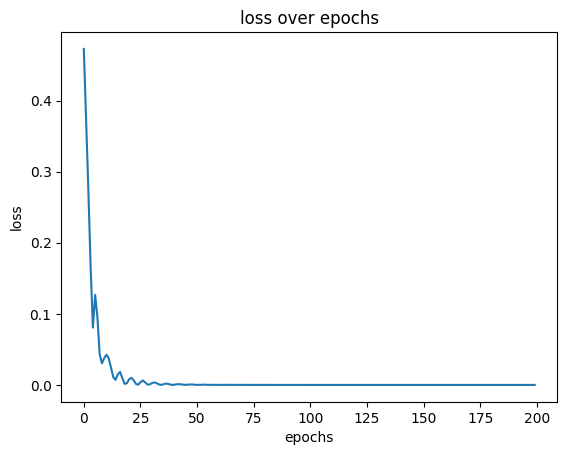

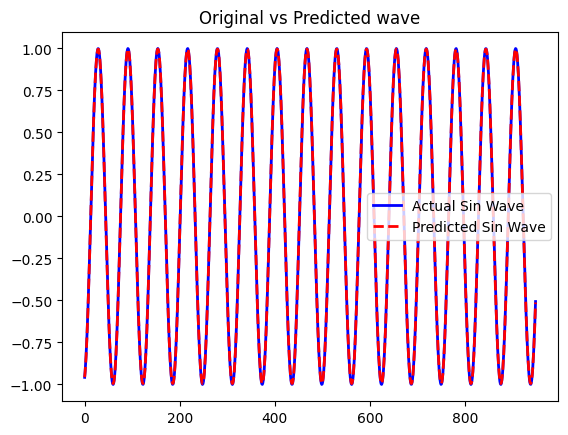

In [195]:
config = parse_config('config/config1.json', VALID_JSON)
learn(config)

### Test 2
* "lr":0.001,
* "act_f":"relu",
* "hidden_size":128,
* "num_layers":2,
* "epochs":200,
* "seq_len":50

Epoch 0/200 finished with avg loss: 0.5141767859458923
Epoch 20/200 finished with avg loss: 0.0702333152294159
Epoch 40/200 finished with avg loss: 0.0056855157017707825
Epoch 60/200 finished with avg loss: 0.00030457237153314054
Epoch 80/200 finished with avg loss: 3.553850547177717e-05
Epoch 100/200 finished with avg loss: 0.0010908638359978795
Epoch 120/200 finished with avg loss: 2.0467143258429132e-05
Epoch 140/200 finished with avg loss: 1.1672889741021208e-05
Epoch 160/200 finished with avg loss: 1.405371904183994e-06
Epoch 180/200 finished with avg loss: 2.8610799063244485e-07


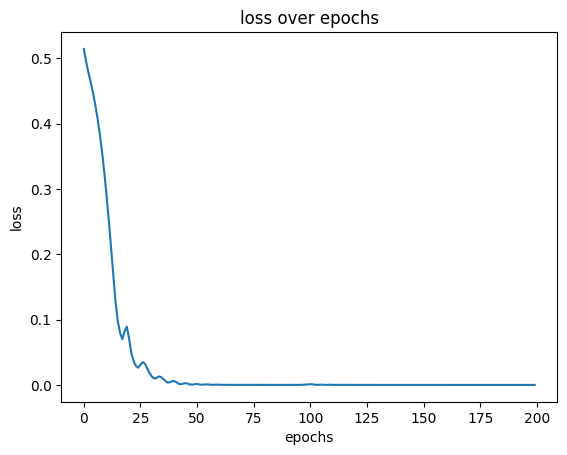

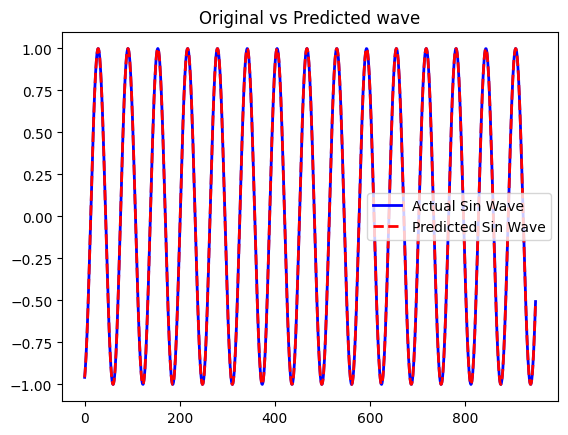

In [196]:
config = parse_config('config/config2.json', VALID_JSON)
learn(config)

### Test 3
* "lr":0.001,
* "act_f":"tanh",
* "hidden_size":128,
* "num_layers":1,
* "epochs":200,
* "seq_len":50

Epoch 0/200 finished with avg loss: 0.4250028431415558
Epoch 20/200 finished with avg loss: 0.012223520316183567
Epoch 40/200 finished with avg loss: 0.001507515786215663
Epoch 60/200 finished with avg loss: 0.00019009127572644502
Epoch 80/200 finished with avg loss: 0.00010877711611101404
Epoch 100/200 finished with avg loss: 7.5754382123705e-05
Epoch 120/200 finished with avg loss: 6.487542850663885e-05
Epoch 140/200 finished with avg loss: 5.7291916164103895e-05
Epoch 160/200 finished with avg loss: 5.1814109610859305e-05
Epoch 180/200 finished with avg loss: 4.75053493573796e-05


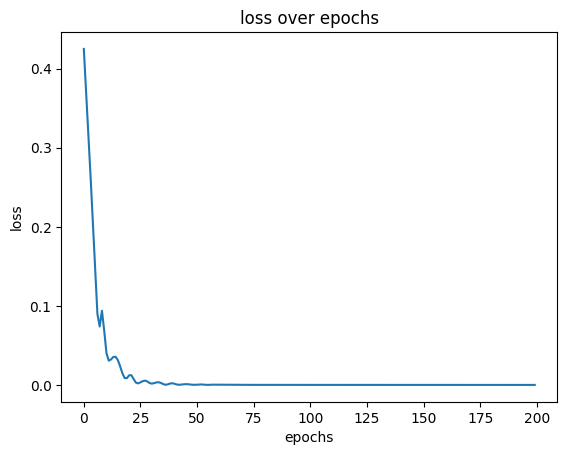

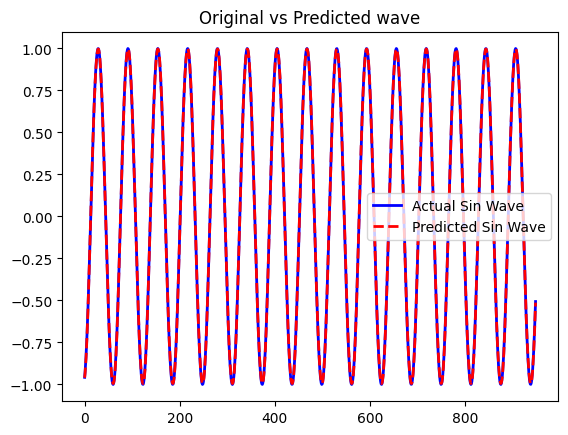

In [197]:
config = parse_config('config/config3.json', VALID_JSON)
learn(config)

### Test 4
* "lr":0.001,
* "act_f":"tanh",
* "hidden_size":1,
* "num_layers":2,
* "epochs":200,
* "seq_len":50

Epoch 0/200 finished with avg loss: 0.5701999068260193
Epoch 20/200 finished with avg loss: 0.546149730682373
Epoch 40/200 finished with avg loss: 0.530112624168396
Epoch 60/200 finished with avg loss: 0.5195595622062683
Epoch 80/200 finished with avg loss: 0.5119926929473877
Epoch 100/200 finished with avg loss: 0.5058989524841309
Epoch 120/200 finished with avg loss: 0.5004591941833496
Epoch 140/200 finished with avg loss: 0.49511826038360596
Epoch 160/200 finished with avg loss: 0.48932623863220215
Epoch 180/200 finished with avg loss: 0.48238328099250793


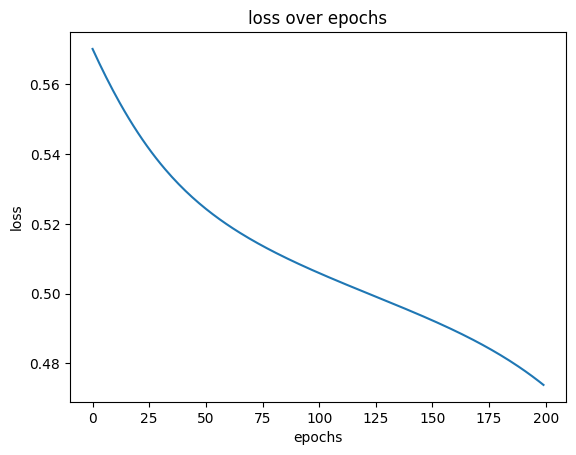

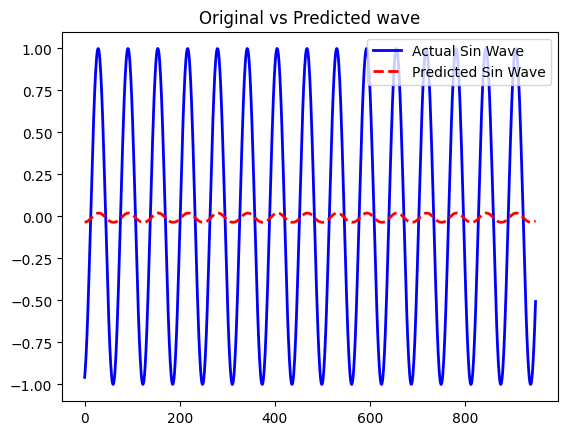

In [201]:
config = parse_config('config/config4.json', VALID_JSON)
learn(config)

### Test 5
* "lr":0.001,
* "act_f":"tanh",
* "hidden_size":128,
* "num_layers":2,
* "epochs":10,
* "seq_len":50

Epoch 0/10 finished with avg loss: 0.5556456446647644


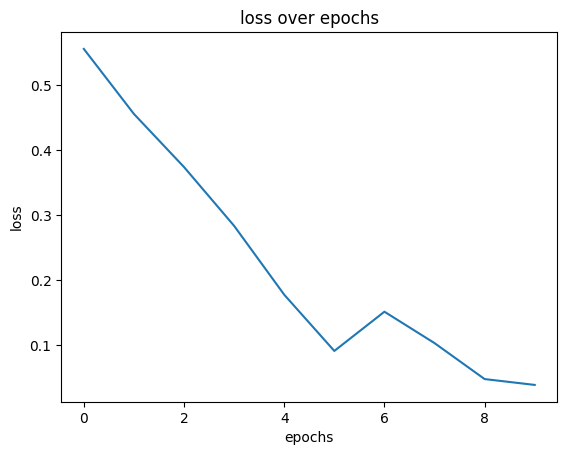

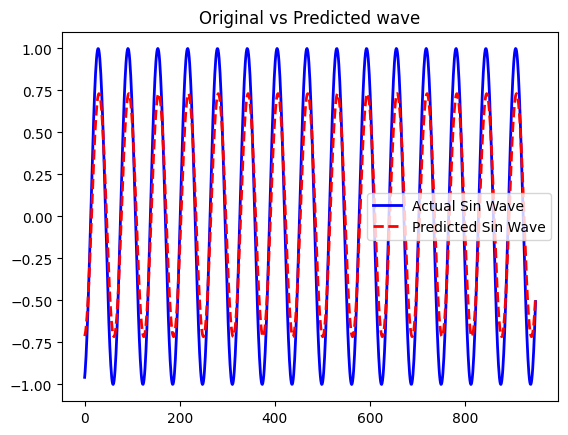

In [199]:
config = parse_config('config/config5.json', VALID_JSON)
learn(config)